In [1]:
import networkx as nx
import custom_funcs as cf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn

from time import time
from collections import defaultdict, Counter
from joblib import Parallel, delayed
from Bio import SeqIO
from Levenshtein import distance
from random import shuffle

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# Read in the graph data and clean it.
G = nx.read_gpickle('20150902_all_ird Final Graph.pkl')
G = cf.clean_host_species_names(G)
G = cf.impute_reassortant_status(G)
G = cf.impute_weights(G)
G = cf.remove_zero_weighted_edges(G)

In [3]:
all_hosts = set([d['host_species'] for n, d in G.nodes(data=True)])
len(all_hosts)

152

In [4]:
len(G.edges())

25683

In [5]:
cf.count_edges(G, attr='host_species')

{'full_complement': {'diff_attr': 3114.6333333333328,
  'same_attr': 13106.366666666669},
 'reassortant': {'diff_attr': 1456.0404761904758,
  'same_attr': 735.9595238095236}}

# Compute propotion of edges reassortant same vs. different

In [6]:
# Proportion reassortant in data
data_props = cf.edge_proportion_reassortant(G, attr='host_species')
data_props

{'diff_attr': 0.3185614499893993, 'same_attr': 0.05316732994746786}

In [7]:
# Proportion reassortant under null
excluded_hosts = ['Aquatic Bird', 'Avian', 'Bird', 'Duck', 'Environment', 'Mallard-Black Duck Hybrid', 'Sea Mammal', 
                  'Unknown', 'Waterfowl']
start = time()
def null_distribution_proportion_reassortant(G, equally=False):
    G_shuffled = cf.shuffle_node_attribute_label(G, 'host_species', equally)
    props = cf.edge_proportion_reassortant(G_shuffled, 'host_species', exclusions=excluded_hosts)
    return props

props_null = Parallel(n_jobs=-1)(delayed(null_distribution_proportion_reassortant)(G, equally=True) for i in range(100))
end = time()
print(end - start)

179.70863699913025


In [8]:
null = pd.DataFrame(props_null)
null.mean()

diff_attr    0.124775
same_attr    0.121502
dtype: float64

In [9]:
data = pd.DataFrame([data_props])
data.mean()

diff_attr    0.318561
same_attr    0.053167
dtype: float64

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


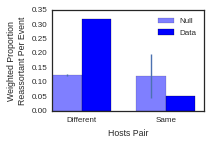

In [10]:
seaborn.set_context("paper")
seaborn.set_style('white')

fig1 = plt.figure(figsize=(3,2))
ax1 = fig1.add_subplot(1,1,1)
ind = np.arange(2)
width = 0.35

ax1.bar(ind, null.mean(), width, color='blue', label='Null', alpha=0.5, yerr=null.std()*3)
ax1.bar(ind+width, data.mean(), width, color='blue', label='Data')
ax1.set_xticks(ind+width)
ax1.set_xticklabels(['Different', 'Same'])
ax1.set_xlabel('Hosts Pair')
ax1.set_ylabel('Weighted Proportion\nReassortant Per Event')
ax1.legend()
plt.subplots_adjust(left=0.2, bottom=0.2)
plt.savefig('figures/Proportion Reassortant.pdf')

# Compute proportion of reassortant by host class

Host classes:

- Wild bird
- Wild mammal
- Domestic bird
- Domestic mammal
- Human

In [11]:
# Open the bird vs. mammal CSV file

host_classes = pd.read_csv('host_groups.csv').drop_duplicates()
# I suspected there may have been duplicates, so I added the drop_duplicates() function call.
host_classes.set_index(['Country', 'Species'], inplace=True)
host_classes.ix['Canada'].ix['American Black Duck']

Habitat/setting        Wild
Bird, Mammal, Human    Bird
Name: American Black Duck, dtype: object

In [12]:
# Impute each node with the appropriate metadata. We will create a new node field: "host_class".

# The try/except coding pattern allows me to iteratively identify things for which we have no labels yet.

for n, d in G.nodes(data=True):
    c = d['country']
    s = d['host_species']
    try:
        hc = host_classes.ix[c].ix[s]
        habt = hc['Habitat/setting']
        host = hc['Bird, Mammal, Human']

        host_class = habt + ' ' + host
        G.node[n]['host_class'] = host_class
    except:
        print(c,s)

In [13]:
data_props = cf.edge_proportion_reassortant(G, attr='host_class')
data_props

{'diff_attr': 0.31026228143213985, 'same_attr': 0.10083275503122831}

In [14]:
# A function that computes the proportion reassortant across different node attributes.

def counts_reassortant_domain_graph(G, node_attr):
    """
    Computes the weighted counts of reassortant edges when going between different node attributes.
    
    Returns a "domain graph" with counts of weighted reasosrtant edges and sum weighted edges.
    """
    hg_graph = nx.DiGraph()

    for n, node_d in G.nodes(data=True):

        in_edges = G.in_edges(n, data=True)
        total_edges = len(in_edges)
        is_reassortant = node_d['reassortant']

        sk_hg = G.node[n][node_attr]
        if sk_hg not in hg_graph.nodes():
            hg_graph.add_node(sk_hg)

        for sc, _, edge_d in in_edges:
            sc_hg = G.node[sc][node_attr]
            if sc_hg not in hg_graph.nodes():
                hg_graph.add_node(sc_hg)

            if (sc_hg, sk_hg) not in hg_graph.edges():
                hg_graph.add_edge(sc_hg, sk_hg, total=edge_d['weight'], reassortant=0)
            if (sc_hg, sk_hg) in hg_graph.edges():
                hg_graph.edge[sc_hg][sk_hg]['total'] += edge_d['weight']

            if is_reassortant:
                hg_graph.edge[sc_hg][sk_hg]['reassortant'] += edge_d['weight']

    for sc, sk, d in hg_graph.edges(data=True):
        hg_graph.edge[sc][sk]['p_reassortant'] = d['reassortant'] / d['total']
        
    return hg_graph


In [93]:
# Compute the proportion reassortant across different host class pairs.
hg = counts_reassortant_domain_graph(G, 'host_class')
# We will ignore edges that involve "unknown" hosts.
for n in hg.nodes():
    if 'Unknown' in n:
        hg.remove_node(n)
# hg.edges(data=True)
hg.edges(data=True)

[('Wild Mammal',
  'Wild Mammal',
  {'p_reassortant': 0.0, 'reassortant': 0, 'total': 2.0}),
 ('Wild Mammal',
  'Domestic Bird',
  {'p_reassortant': 0.5454545454545454, 'reassortant': 3.0, 'total': 5.5}),
 ('Wild Mammal',
  'Human Human',
  {'p_reassortant': 0.0, 'reassortant': 0, 'total': 5.0}),
 ('Wild Mammal',
  'Wild Bird',
  {'p_reassortant': 0.4482758620689655, 'reassortant': 6.5, 'total': 14.5}),
 ('Wild Mammal',
  'Domestic Mammal',
  {'p_reassortant': 0.0, 'reassortant': 0, 'total': 2.0}),
 ('Domestic Bird',
  'Wild Mammal',
  {'p_reassortant': 0.07142857142857142, 'reassortant': 0.5, 'total': 7.0}),
 ('Domestic Bird',
  'Domestic Bird',
  {'p_reassortant': 0.1259698582280538,
   'reassortant': 258.41666666666634,
   'total': 2051.4166666666642}),
 ('Domestic Bird',
  'Human Human',
  {'p_reassortant': 0.1578947368421045,
   'reassortant': 7.499999999999986,
   'total': 47.500000000000135}),
 ('Domestic Bird',
  'Wild Bird',
  {'p_reassortant': 0.2697095435684647, 'reassortant

In [16]:
# A helper function for computing the null distribution.
def null_proportion_domain_graph_reassortant(G, node_attr, equally=False):
    
    G_shuffled = cf.shuffle_node_attribute_label(G, node_attr, equally)
    hg_graph_shuf = counts_reassortant_domain_graph(G_shuffled, node_attr)
    
    return hg_graph_shuf

In [17]:
# Compute the null distribution.
### CAUTION! YOU WILL HAVE TO WAIT 3 MINUTES FOR THIS TO FINISH!
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_domain_graph_reassortant)(G, 'host_class', equally=True) for i in range(100))
len(results)
end = time()
print(end - start)

180.5042848587036


In [18]:
# Summarize the proportion reassortant distribution under null.
def distr_null_p_reassortant(list_of_hg_graphs):
    hg_graph = nx.DiGraph()
    for g in list_of_hg_graphs:
        hg_graph.add_nodes_from(g.nodes())
        for sc, sk, d in g.edges(data=True):
            if (sc, sk) not in hg_graph.edges():
                hg_graph.add_edge(sc, sk, p_reassortant=[d['p_reassortant']])
            else:
                hg_graph.edge[sc][sk]['p_reassortant'].append(d['p_reassortant'])
    return hg_graph

summaryG = distr_null_p_reassortant(results)

In [19]:
# Remove "unknowns" from consideration
for n, d in summaryG.nodes(data=True):
    if 'Unknown' in n:
        summaryG.remove_node(n)
summaryG.nodes(data=True)

[('Wild Mammal', {}),
 ('Domestic Bird', {}),
 ('Human Human', {}),
 ('Wild Bird', {}),
 ('Domestic Mammal', {})]

In [80]:
# Grab out the "null" model statistics.
means = []  # mean of the distribution under null.
stds  = []  # standard deviation of distribution under null.
names = []  # names
# grab out the 1st, 5th, 95th and 99th percentile of null distribution
percs = dict()
for p in [1, 5, 95, 99]:
    percs[p] = []

name_map = {'Domestic Bird': 'DB',
            'Wild Bird': 'WB',
            'Human Human': 'H',
            'Domestic Mammal': 'DM',
            'Wild Mammal': 'WM'}

# Reverse name_map for convenience
key_map = {v:k for k, v in name_map.items()}

for sc, sk, d in sorted(summaryG.edges(data=True), key=lambda x:(x[0], x[1])):
    mean = np.mean(d['p_reassortant'])
    std = np.std(d['p_reassortant'])

    names.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
    means.append(mean)
    stds.append(std)
    for p in [1, 5, 95, 99]:
        percs[p].append(np.percentile(d['p_reassortant'], p))

In [79]:
summaryG.edges(data=True)

[('Wild Mammal',
  'Wild Mammal',
  {'p_reassortant': [0.07090608912991142,
    0.11769681485677908,
    0.10701178109940104,
    0.11385994595049799,
    0.10150740479548662,
    0.09842114493529516,
    0.09243340526318689,
    0.12081067545052969,
    0.11823778533017681,
    0.12865266335330794,
    0.09403433920741969,
    0.1274428064232054,
    0.1346994128871601,
    0.09149910686976791,
    0.13454937029910816,
    0.1059874201533379,
    0.1147545659880246,
    0.1216471356276682,
    0.13727030906071583,
    0.09395803923059756,
    0.11573209780161348,
    0.08643577182937814,
    0.10167221599525292,
    0.10403288709573255,
    0.1486937473202212,
    0.11485514028583219,
    0.12809769502316887,
    0.10068930087760335,
    0.1141341738290335,
    0.13455556742112598,
    0.16792065937692416,
    0.10250334953259602,
    0.11050125973832099,
    0.09990846894925473,
    0.11230339441053977,
    0.1079852989424756,
    0.16509098864645544,
    0.1373545214141989,
    0.12

In [41]:
percs

{1: [0.082493316788398136,
  0.068579300374833924,
  0.087142599411448793,
  0.085764614813770346,
  0.079629143253494808,
  0.082424345952377534,
  0.082819325997461543,
  0.087329693851538034,
  0.086412048225086552,
  0.082644167811624314,
  0.087656243630909694,
  0.086994955140297134,
  0.081065581069344583,
  0.084918246824573371,
  0.091020957597473168,
  0.082624682411274769,
  0.073894899800958522,
  0.087514021095615638,
  0.084946898580734675,
  0.085179427008563971,
  0.073906344445166985,
  0.079569789062981539,
  0.086243772621096296,
  0.084619735287114486,
  0.071489740532546642],
 5: [0.087876646004529213,
  0.085784609329605896,
  0.091166034804316037,
  0.088469660345250764,
  0.09000863095663246,
  0.087841805608577073,
  0.090930172804228188,
  0.095751624718628775,
  0.094696014826169281,
  0.088898285358609011,
  0.094131407967898512,
  0.090955299480539265,
  0.089053703589947103,
  0.089996151328674959,
  0.09807632716937055,
  0.090908062022034164,
  0.0944421

In [305]:
# Compile the "data" statistics.
data = []
names_data = []
log10weights = []
log10reassort = []
for sc, sk, d in sorted(hg.edges(data=True), key=lambda x:(x[0], x[1])):
    if sc == 'Unknown' or sk == 'Unknown':
        pass
    else:
        names_data.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
        data.append(d['p_reassortant'])
        log10weights.append(np.log10(d['total']))
        log10reassort.append(np.log10(d['reassortant']))
data

[0.1259698582280538,
 0.1829787234042553,
 0.1578947368421045,
 0.2697095435684647,
 0.07142857142857142,
 0.43157894736842106,
 0.07272017692207625,
 0.047619047619047616,
 0.5,
 0.0,
 0.0,
 0.13550815558343773,
 0.0005271481286241328,
 0.14285714285714285,
 0.0,
 0.4435975609756098,
 0.38461538461538464,
 0.625,
 0.30611031859248783,
 0.5714285714285714,
 0.5454545454545454,
 0.0,
 0.0,
 0.4482758620689655,
 0.0]

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


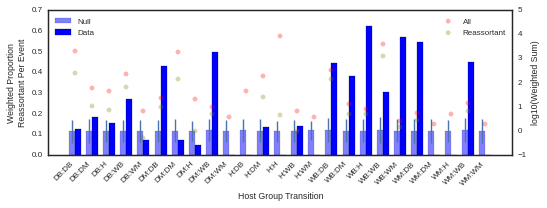

In [306]:
# Plot data vs. null model.
fig = plt.figure(figsize=(7.5,3))

ind = np.arange(len(means))
width = 0.35

ax = fig.add_subplot(1,1,1)
ax.bar(ind, means, width=width, color='blue', label='Null', yerr=np.array(stds)*3, alpha=0.5)
ax.bar(ind+width, data, width=width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylabel('Weighted Proportion\nReassortant Per Event')
ax.set_xlabel('Host Group Transition')


ax2 = ax.twinx()
ax2.scatter(ind+width, log10weights, color='red', label='All', alpha=0.3)
ax2.scatter(ind+width, log10reassort, color='olive', label='Reassortant', alpha=0.3)
ax2.set_ylabel('log10(Weighted Sum)')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
# plt.legend()
plt.subplots_adjust(left=0.08, right=0.94, bottom=0.23)
plt.savefig('figures/Proportion Reassortant Ecological.pdf')

In [307]:
# # Try plotting as a square matrix of circles.
# # Area of circle corresponds to proportion. 
# # Color = blue.
# # Alpha = significance. 1% = 1.0 alpha, 5% = 0.5 alpha, less than that = 0 alpha.

# # Set up the X,Y indices for each of the host groups.
# indices = dict()
# for i, nm in enumerate(sorted(name_map.values())):
#     indices[nm] = i
    
# # Iterate over the names, and plot the circles.
# fig = plt.figure(figsize=(3,3))
# ax = fig.add_subplot(111)
# plt.xlim(-0.5,4.5)
# plt.ylim(-0.5,4.5)

# def color(datum, means, index):
#     """
#     Color determined by direction of effect relative to null.
#     """
#     if datum > means[index]:
#         return 'red'
#     if datum < means[index]:
#         return 'blue'
    
# def radius(sc, sk, hg):
#     """
#     Radius determined by fractional weight of that group.
#     """
#     sum_weight = sum([d['total'] for _,_,d in hg.edges(data=True)])
    
#     weight = hg.edge[sc][sk]['total']
    
#     r = np.sqrt(weight / sum_weight)
    
#     return r

# def alpha(datum, sc, sk, summaryG):
#     """
#     Alpha determined by statistical significance.
#     """
#     p = np.percentile(datum, summaryG.edge[key_map[sc]][key_map[sk]]['p_reassortant'])[0]
#     if p < 0.5:
#         a = (0.5 - p) / 0.5
#     if p > 0.5:
#         a = (p - 0.5) / 0.5
#     if p == 0.5:
#         a = 0
#     print(p, sc, sk, a)
#     return a
# # sig_alpha = dict()
# # sig_alpha[1] = 1.0
# # sig_alpha[5] = 0.6
# # sig_alpha[np.nan] = 0.3

# for i, name in enumerate(names):
#     sc = name.split(':')[0]
#     sk = name.split(':')[1]
    
#     # Plot the circle.
#     x = indices[sk]
#     y = indices[sc]
    
#     # a = np.sqrt(data[i]) # represent proportion by alpha
#     a = alpha(data[i], sc, sk, summaryG)  # alpha represents effect size
#     # sig = si/gnificance(data[i], means, i, percs)
#     # r = sig_alpha[sig] * 0.4# represent significance by radius * 0.5
#     # r = radius(data[i], means, i)
#     r = radius(key_map[sc], key_map[sk], hg)
#     col = color(data[i], means, i)
    
#     c = plt.Circle((x, y), radius=r / 2, color=col, alpha=a)
#     ax.add_artist(c)
# ind = np.arange(0,5)
# ax.set_xticks(ind)
# ax.set_xticklabels(sorted(name_map.values()))
# ax.set_yticks(ind)
# ax.set_yticklabels(sorted(name_map.values()))
# ax.set_xlabel('Sink')
# ax.set_ylabel('Source')
# for spine in ax.spines.keys():
#     ax.spines[spine].set_visible(False)
# plt.show()

In [104]:
p = np.percentile(data[i], summaryG.edge[key_map[sc]][key_map[sk]]['p_reassortant'])[0]


0.0

# Compute proportion reassortant over different host COI distances

In [279]:
# Open the host COI data
host_coi = [s for s in SeqIO.parse('host_coi_trimmed.fasta', 'fasta')]
# Modify the SeqRecord ID such that it only contains the host species name.
for s in host_coi:
    s.id = s.id.split('.')[0].replace('_', ' ')
host_coi = SeqIO.to_dict(host_coi)
host_coi

{'American Black Duck': SeqRecord(seq=Seq('ATCCGGGCAGAGCTAGGCCAGCCAGGGACCCTCCTGGGCGACGACCAAATTTAT...TTT', SingleLetterAlphabet()), id='American Black Duck', name='American_Black_Duck.Anas_rubripes', description='American_Black_Duck.Anas_rubripes', dbxrefs=[]),
 'American Green-Winged Teal': SeqRecord(seq=Seq('ATCCGCGCAGAACTAGGCCAACCAGGAACCCTCCTGGGCGACGACCAAATTTAC...TTT', SingleLetterAlphabet()), id='American Green-Winged Teal', name='American_Green-Winged_Teal.Anas_carolinensis', description='American_Green-Winged_Teal.Anas_carolinensis', dbxrefs=[]),
 'American Wigeon': SeqRecord(seq=Seq('ATCCGCGCAGAACTAGGCCAACCAGGGACCCTCCTGGGCGACGACCAAATTTAC...TTT', SingleLetterAlphabet()), id='American Wigeon', name='American_Wigeon.Anas_americana', description='American_Wigeon.Anas_americana', dbxrefs=[]),
 'Baikal Teal': SeqRecord(seq=Seq('ATGGCCCCAAATATCCGCAAATCCCACCCCCTACTAAAAATAATCAACAACTCC...ACC', SingleLetterAlphabet()), id='Baikal Teal', name='Baikal_Teal.Anas_formosa', description='Baikal_T

In [280]:
# Figure out which sequences have gaps. I suspect that the alignment quality might be compromised by those sequences.
ignored = []
for k, sequence in host_coi.items():
    if '-' in str(sequence.seq):
        ignored.append(k)
#         print(sequence.seq)
ignored

['Domestic Cat',
 'Human',
 'Kelp Gull',
 'Chicken',
 'Redhead',
 'Herring Gull',
 'Baikal Teal',
 'Cinnamon Teal',
 'Blue-Winged Teal']

In [281]:
# Impute the COI sequence based on the host species name, ignoring the sequences that have gaps in them. 
for n, d in G.nodes(data=True):    
    try:
        hs = d['host_species']
        assert hs not in ignored
        G.node[n]['coi_sequence'] = host_coi[hs]
    except:
        G.node[n]['coi_sequence'] = None

In [308]:
# Compute proportion under data. 
def proportion_reassortant_coi(G):
    data = dict()

    bins = np.arange(0,0.3,0.02)
    for b in bins:
        data[b] = dict()
        data[b]['reassortant'] = 0
        data[b]['clonal'] = 0

    for sc, sk, d in G.edges(data=True):
        sc_coi = G.node[sc]['coi_sequence']
        sk_coi = G.node[sk]['coi_sequence']
        if sc_coi and sk_coi:
            dist = distance(str(sc_coi.seq), str(sk_coi.seq)) / len(str(sc_coi.seq))
            b = bins[int(np.digitize(dist, bins)) - 1] 
            if d['edge_type'] == 'reassortant':
                data[b]['reassortant'] += d['weight']
            else:
                data[b]['clonal'] += d['weight']  
    return data

coi_data = proportion_reassortant_coi(G)

In [309]:
coi_data

{0.0: {'clonal': 3005.0000000000027, 'reassortant': 505.45952380952394},
 0.02: {'clonal': 3.0, 'reassortant': 0.5},
 0.040000000000000001: {'clonal': 57.0, 'reassortant': 17.75},
 0.059999999999999998: {'clonal': 272.5, 'reassortant': 154.34523809523813},
 0.080000000000000002: {'clonal': 33.0, 'reassortant': 31.5},
 0.10000000000000001: {'clonal': 41.0, 'reassortant': 26.0},
 0.12: {'clonal': 2.0, 'reassortant': 2.5},
 0.14000000000000001: {'clonal': 16.0, 'reassortant': 16.666666666666664},
 0.16: {'clonal': 33.0, 'reassortant': 53.166666666666664},
 0.17999999999999999: {'clonal': 35.0, 'reassortant': 20.0},
 0.20000000000000001: {'clonal': 38.0, 'reassortant': 5.5},
 0.22: {'clonal': 0, 'reassortant': 0},
 0.23999999999999999: {'clonal': 0, 'reassortant': 0},
 0.26000000000000001: {'clonal': 0, 'reassortant': 0},
 0.28000000000000003: {'clonal': 0, 'reassortant': 0}}

In [285]:
# Compute proportion under null: shuffle host COIs
def null_proportion_reassortant_coi(G):
    host_cois = [d['coi_sequence'] for n, d in G.nodes(data=True)]
    shuffle(host_cois)

    G_shuffled = G.copy()
    for i, (n, d) in enumerate(G_shuffled.nodes(data=True)):
        G_shuffled.node[n]['coi_sequence'] = host_cois[i]
    
    return proportion_reassortant_coi(G_shuffled)    

In [30]:
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_reassortant_coi)(G) for i in range(500))
end = time()
print(end - start)

880.5899322032928


In [286]:
# Aggregate the results into clonal and reassortant

agg = dict()
agg['clonal'] = defaultdict(list)
agg['reassortant'] = defaultdict(list)

for result in results:
    for dist, d in result.items():
        agg['clonal'][dist].append(d['clonal'])
        agg['reassortant'][dist].append(d['reassortant'])

In [287]:
agg['clonal'][0.12]

[1.0434782608695652,
 3.5,
 7.035714285714286,
 4.0,
 7.0,
 3.2539682539682544,
 3.0,
 2.037037037037037,
 4.0,
 6.125,
 3.0,
 1.1481481481481481,
 1.0,
 3.333333333333333,
 2.0,
 2.0,
 3.4074074074074074,
 11.142857142857142,
 2.0,
 4.0,
 4.333333333333333,
 2.0,
 1.5,
 6.0,
 1.0,
 3.037037037037037,
 4.5,
 3.0,
 0.5833333333333333,
 5.333333333333333,
 1.0,
 5.2,
 2.537037037037037,
 0.5,
 3.0,
 6.037037037037037,
 1.0,
 0,
 7.037037037037037,
 3.0,
 3.5,
 3.0,
 3.0,
 3.04,
 6.0,
 3.037037037037037,
 4.037037037037037,
 3.0,
 3.0,
 3.0,
 1.6666666666666667,
 0,
 2.333333333333333,
 2.5,
 3.0,
 6.415,
 7.0,
 1.5,
 4.041666666666667,
 2.537037037037037,
 3.0,
 2.3333333333333335,
 3.0,
 4.5,
 0,
 5.0,
 3.5,
 4.037037037037037,
 5.0,
 4.037037037037037,
 2.0,
 1.037037037037037,
 5.037037037037037,
 1.5069312169312168,
 5.0,
 6.078703703703704,
 2.5,
 0,
 0.75,
 3.0,
 1.0,
 4.0,
 1.8333333333333333,
 5.0,
 4.0,
 5.0,
 1.8703703703703702,
 3.0,
 3.642857142857143,
 3.0,
 5.66666666666666

In [288]:
agg['reassortant'][0.12]

[1.5,
 1.0,
 0.5,
 0,
 0.5,
 0.5,
 0.5,
 1.0,
 0.5,
 1.5,
 1.0,
 0,
 0,
 0.5,
 0,
 0,
 0.5,
 0.5555555555555556,
 0,
 0,
 1.0,
 1.0,
 0.5,
 0.5,
 1.0,
 0.5,
 1.5,
 0,
 0,
 1.0,
 1.0,
 0,
 0,
 0.5,
 0.5,
 0,
 0.5,
 0,
 0,
 0.5,
 1.0833333333333333,
 0,
 1.0,
 0.05555555555555555,
 0,
 1.0,
 1.0833333333333335,
 0.05555555555555555,
 0.5,
 0,
 1.0,
 0,
 0,
 0.5,
 0.8055555555555556,
 0,
 0.5,
 0.5,
 0.5,
 0.75,
 0,
 0,
 1.125,
 0.5,
 0.8333333333333333,
 0,
 0.5,
 0.5,
 0,
 0.5,
 0.75,
 0,
 0,
 0,
 0.5,
 0,
 0.5,
 0,
 0,
 0.5,
 0.6825396825396826,
 0,
 0,
 0,
 0.5,
 0,
 0,
 0,
 0.5,
 0,
 0.5555555555555556,
 0.16666666666666666,
 1.0,
 0.043478260869565216,
 1.5,
 0.5,
 0,
 0,
 0,
 0.1111111111111111,
 0.16666666666666666,
 0.5,
 0.16666666666666666,
 1.0,
 0,
 0.55,
 1.0,
 1.125,
 0,
 0.5,
 2.5,
 0.5,
 0,
 0.125,
 0.021739130434782608,
 0,
 1.0555555555555556,
 0.6666666666666666,
 0,
 0.25,
 0.5,
 1.0,
 0,
 2.5,
 0,
 0.5,
 1.3,
 0.05555555555555555,
 0.5,
 1.0,
 1.5,
 1.0,
 0.25,
 0,
 

In [289]:
# We want to compute the proportion reassortant under the null.
# Iterate over the clonal. 

prop_null = defaultdict(list)

for d, cts in agg['reassortant'].items():
    for i, ct in enumerate(cts):
        try:
            prop_null[d].append(ct / (ct + agg['clonal'][d][i]))
        except:
            prop_null[d].append(np.nan)
prop_null

defaultdict(list,
            {0.0: [0.1188827849419655,
              0.11551032321154564,
              0.12776151929432228,
              0.10855274775439515,
              0.1255041342535327,
              0.10836672996345778,
              0.11049875733060233,
              0.15265752071736896,
              0.11460678996590086,
              0.10029040124922405,
              0.10456996748232063,
              0.1386364709659979,
              0.12452263849310082,
              0.10932793323704158,
              0.12073437626227002,
              0.12066589752978961,
              0.10679358445461494,
              0.13382536505816095,
              0.12434904147226629,
              0.10214143057652691,
              0.10322584941300791,
              0.12486777367758829,
              0.12971470111563863,
              0.11753917945051714,
              0.11719497335489112,
              0.09800694204135212,
              0.1277182410180907,
              0.10598663223973186,
 

In [290]:
prop_null[0.12]

[0.5897435897435896,
 0.2222222222222222,
 0.06635071090047394,
 0.0,
 0.06666666666666667,
 0.13319238900634248,
 0.14285714285714285,
 0.3292682926829268,
 0.1111111111111111,
 0.19672131147540983,
 0.25,
 0.0,
 0.0,
 0.13043478260869565,
 0.0,
 0.0,
 0.12796208530805686,
 0.0474898236092266,
 0.0,
 0.0,
 0.1875,
 0.3333333333333333,
 0.25,
 0.07692307692307693,
 0.5,
 0.1413612565445026,
 0.25,
 0.0,
 0.0,
 0.15789473684210528,
 0.5,
 0.0,
 0.0,
 0.5,
 0.14285714285714285,
 0.0,
 0.3333333333333333,
 nan,
 0.0,
 0.14285714285714285,
 0.23636363636363636,
 0.0,
 0.25,
 0.017946877243359655,
 0.0,
 0.2477064220183486,
 0.21157323688969262,
 0.01818181818181818,
 0.14285714285714285,
 0.0,
 0.37499999999999994,
 nan,
 0.0,
 0.16666666666666666,
 0.21167883211678834,
 0.0,
 0.06666666666666667,
 0.25,
 0.11009174311926605,
 0.22816901408450704,
 0.0,
 0.0,
 0.2727272727272727,
 0.1,
 1.0,
 0.0,
 0.125,
 0.11020408163265305,
 0.0,
 0.11020408163265305,
 0.2727272727272727,
 0.0,
 0.0,
 0

In [291]:
null_mean = pd.DataFrame(prop_null).mean()
null_mean = null_mean.reset_index()
null_mean.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']
null_mean

null_std = pd.DataFrame(prop_null).std()
null_std = null_std.reset_index()
null_std.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

# Null buttom error range = 0.025
null_b = pd.DataFrame(prop_null).quantile(0.025)
null_b = null_b.reset_index()
null_b.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

# Null top error range = 0.975
null_t = pd.DataFrame(prop_null).quantile(0.975)
null_t = null_t.reset_index()
null_t.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

In [ ]:
# Plot this data

## 1 November 2015:
## TODO: Rather than plot std*3 or std*5, plot 95% interval from the null. 
## Use the axes.errorbar API: http://matplotlib.org/api/axes_api.html
## [ ] DONE

df = pd.DataFrame(coi_data).T
df['prop'] = df['reassortant'] / (df['clonal'] + df['reassortant'])

proportions = df['prop'].dropna().reset_index()
proportions.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

ixcol = 'Host COI Hamming Distance'
summary = proportions.set_index(ixcol).join(null_mean.set_index(ixcol), rsuffix='r').join(null_std.set_index(ixcol), rsuffix='s')
summary = summary.join(null_b.set_index(ixcol), rsuffix='r').join(null_t.set_index(ixcol), rsuffix='rr')
summary.columns = ['data', 'null', 'std', '2.5', '97.5']
summary['2.5'] = summary['null'] - summary['2.5']
summary['97.5'] = summary['97.5'] - summary['null']

fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
ax.errorbar(x=summary.index, y=summary['null'], yerr=[summary['2.5'], summary['97.5']], color='blue', alpha=0.3, label='Null')
ax.errorbar(x=summary.index, y=summary['data'], color='blue', label='Data')

total_counts = df[['reassortant', 'clonal']].apply(lambda x:np.log10(x)).reset_index()
total_counts.columns = ['Host COI Hamming Distance', 'Reassortant', 'Clonal']
total_counts.replace(-np.inf, np.nan, inplace=True)
total_counts.dropna(inplace=True)
total_counts.set_index('Host COI Hamming Distance', inplace=True)

# total_counts.plot(x='Host COI Hamming Distance', y='Reassortant', color='green', alpha=0.3, ax=ax, secondary_y=True)
ax2 = ax.twinx()
ax2.scatter(x=total_counts.index, 
         y=total_counts['Reassortant'], 
         color='red', 
         label='Reassortant', alpha=0.3)
# total_counts.plot(x='Host COI Hamming Distance', y='Clonal', color='blue', alpha=0.3, ax=ax)
ax2.scatter(x=total_counts.index, 
         y=total_counts['Clonal'], 
         color='olive', 
         label='Clonal Descent', alpha=0.3)
ax2.legend(loc='upper right')
ax.legend(loc='upper left')
ax.set_xlim(-0.005, 0.205)
ax.set_ylabel('Weighted\nProportion Reassortant')
ax2.set_ylabel('log10(Weighted Sum)')
ax.set_xlabel('Host COI Distance')

plt.subplots_adjust(left=0.15, right=0.85)
plt.savefig('figures/Proportion Reassortant COI.pdf')

/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [243]:
summary['data']

Host COI Hamming Distance
0.00    0.143987
0.02    0.142857
0.04    0.237458
0.06    0.361595
0.08    0.488372
0.10    0.388060
0.12    0.555556
0.14    0.510204
0.16    0.617021
0.18    0.363636
0.20    0.126437
Name: data, dtype: float64

In [236]:
list(summary.index)

[0.0,
 0.02,
 0.040000000000000001,
 0.059999999999999998,
 0.080000000000000002,
 0.10000000000000001,
 0.12,
 0.14000000000000001,
 0.16,
 0.17999999999999999,
 0.20000000000000001]

In [216]:
errors

,2.5,97.5
Host COI Hamming Distance,,
0.00,0.094681,0.148146
0.02,0.000000,1.000000
0.04,0.023992,0.277176
0.06,0.069802,0.178664
0.08,0.026333,0.268411
0.10,0.045310,0.219446
0.12,0.000000,0.549570
0.14,0.000000,0.291714
0.16,0.068323,0.178728


In [163]:
summary['3sigma'] = summary['null'] + summary['std'] * 3
# summary[summary['data'] > summary['3sigma']]
summary

,data,null,std,2.5,97.5,3sigma
Host COI Hamming Distance,,,,,,
0.00,0.143987,0.119619,0.013807,0.094681,0.148146,0.161039
0.02,0.142857,0.230134,0.413181,0.000000,1.000000,1.469677
0.04,0.237458,0.122243,0.063477,0.023992,0.277176,0.312675
0.06,0.361595,0.121258,0.029200,0.069802,0.178664,0.208858
0.08,0.488372,0.123571,0.061511,0.026333,0.268411,0.308105
0.10,0.388060,0.118435,0.044528,0.045310,0.219446,0.252020
0.12,0.555556,0.138533,0.179741,0.000000,0.549570,0.677758
0.14,0.510204,0.121313,0.072703,0.000000,0.291714,0.339423
0.16,0.617021,0.119352,0.026806,0.068323,0.178728,0.199769


/home/ericmjl/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


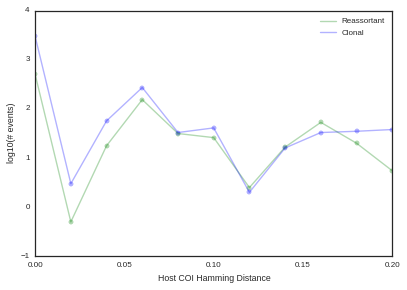

In [252]:
total_counts = df[['reassortant', 'clonal']].apply(lambda x:np.log10(x)).reset_index()
total_counts.columns = ['Host COI Hamming Distance', 'Reassortant', 'Clonal']
total_counts.replace(-np.inf, np.nan, inplace=True)
total_counts.dropna(inplace=True)

ax = total_counts.plot(x='Host COI Hamming Distance', y='Reassortant', color='green', alpha=0.3)
total_counts.plot(x='Host COI Hamming Distance', y='Reassortant', color='green', alpha=0.3, kind='scatter', ax=ax)
total_counts.plot(x='Host COI Hamming Distance', y='Clonal', color='blue', alpha=0.3, ax=ax)
total_counts.plot(x='Host COI Hamming Distance', y='Clonal', color='blue', alpha=0.3, kind='scatter', ax=ax)
plt.ylabel('log10(# events)')